# Tutorial Básico #EX12
# Series temporales LSTM para predicción de energía eléctrica


Dado el aumento de los medidores de electricidad inteligentes y la amplia adopción de la tecnología de generación de electricidad, como los paneles solares, existe una gran cantidad de datos de uso de electricidad disponibles.

Estos datos representan una serie temporal multivariada de variables relacionadas con la energía que a su vez podrían usarse para modelar e incluso pronosticar el consumo de electricidad futuro.

A diferencia de otros algoritmos de aprendizaje automático, las redes neuronales recurrentes de memoria a corto plazo son capaces de aprender automáticamente las características de los datos de secuencia, admiten datos de múltiples variables y pueden generar secuencias de longitud variable que pueden usarse para pronósticos de varios pasos.

En este tutorial, descubrirá cómo desarrollar redes neuronales recurrentes de memoria a largo plazo para la predicción de series de tiempo de varios pasos del consumo de energía en el hogar.

Este tutorial está dividido en nueve partes; son:

Descripción del problema
Cargar y preparar conjunto de datos
Evaluación modelo
LSTM para pronósticos de varios pasos
Modelo LSTM con entrada univariada y salida vectorial
Modelo LSTM de codificador-decodificador con entrada univariante
Modelo LSTM de codificador-decodificador con entrada multivariante
Modelo de codificador-decodificador CNN-LSTM con entrada univariante
Modelo de codificador-decodificador ConvLSTM con entrada univariante

# Descripción del problema

El conjunto de datos ' Consumo de energía doméstica ' es un conjunto de datos de series temporales multivariadas que describe el consumo de electricidad para un solo hogar durante cuatro años.

Los datos se recopilaron entre diciembre de 2006 y noviembre de 2010 y las observaciones del consumo de energía dentro del hogar se recopilaron cada minuto.

Es una serie multivariada compuesta por siete variables (además de la fecha y la hora); son:

global_active_power : la potencia activa total consumida por el hogar (kW).

global_reactive_power : la potencia reactiva total consumida por el hogar (kW).

voltaje : voltaje medio (V).

intensidad_global : intensidad de corriente promedio (A).

sub_metering_1 : energía activa para la cocina (W-hora de energía activa).

sub_metering_2 : Energía activa para lavar la ropa (W-hora de energía activa).

sub_metering_3 : Energía activa para sistemas de control climático (W-hora de energía activa).

Se puede crear una cuarta variable de submedición restando la suma de tres variables de submedición definidas de la energía activa total de la siguiente manera

sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)

# Cargar y preparar conjunto de datos

Podemos usar la función read_csv () para cargar los datos y combinar las dos primeras columnas en una sola columna de fecha y hora que podemos usar como índice.



In [3]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric

dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

A continuación, podemos marcar todos los valores faltantes indicados con un ' ? ' con un valor NaN , que es un flotante.

Esto nos permitirá trabajar con los datos como una matriz de valores de coma flotante en lugar de tipos mixtos (menos eficiente).

In [5]:
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

También necesitamos completar los valores faltantes ahora que han sido marcados.

Un enfoque muy simple sería copiar la observación desde la misma hora del día anterior. Podemos implementar esto en una función llamada fill_missing () que tomará la matriz NumPy de los datos y copiará los valores de hace exactamente 24 horas

In [6]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

Podemos aplicar esta función directamente a los datos dentro del DataFrame.

In [7]:
# fill missing
fill_missing(dataset.values)

Ahora podemos crear una nueva columna que contenga el resto de la submedición, utilizando el cálculo de la sección anterior.

In [8]:
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

Ahora podemos guardar la versión limpia del conjunto de datos en un nuevo archivo; en este caso simplemente cambiaremos la extensión del archivo a .csv y guardaremos el conjunto de datos como ' hogar_consumo_consumo.csv '.

In [10]:
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

Al unir todo esto, el ejemplo completo de cargar, limpiar y guardar el conjunto de datos se enumera a continuación.

Ejecutar el ejemplo crea el nuevo archivo ' hogar_poder_consumo.csv ' que podemos usar como punto de partida para nuestro proyecto de modelado.

In [11]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric

# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

# Evaluación modelo

En esta sección, consideraremos cómo podemos desarrollar y evaluar modelos predictivos para el conjunto de datos de energía del hogar.

Esta sección está dividida en cuatro partes; son:

Enmarcado del problema
Métrica de evaluación
Conjuntos de tren y prueba
Validación de avance

Hay muchas formas de aprovechar y explorar el conjunto de datos de consumo de energía del hogar.

En este tutorial, utilizaremos los datos para explorar una pregunta muy específica; es decir:

Dado el consumo de energía reciente, ¿cuál es el consumo de energía esperado para la próxima semana?

Esto requiere que un modelo predictivo pronostique la potencia activa total para cada día durante los próximos siete días.

Técnicamente, este marco del problema se conoce como un problema de pronóstico de series de tiempo de varios pasos, dados los múltiples pasos de pronóstico. Un modelo que hace uso de múltiples variables de entrada puede denominarse un modelo de pronóstico de series de tiempo multivariadas de varios pasos.

Un modelo de este tipo podría ser útil dentro del hogar para planificar los gastos. También podría ser útil en el lado de la oferta para planificar la demanda de electricidad para un hogar específico.

Este marco del conjunto de datos también sugiere que sería útil reducir las observaciones por minuto del consumo de energía a los totales diarios. Esto no es obligatorio, pero tiene sentido, dado que estamos interesados en la potencia total por día.

Podemos lograr esto fácilmente usando la función resample () en el DataFrame de pandas. Llamar a esta función con el argumento 'D' permite que los datos cargados indexados por fecha-hora se agrupen por día (ve todos los alias de desplazamiento). Luego podemos calcular la suma de todas las observaciones para cada día y crear un nuevo conjunto de datos de consumo diario de energía para cada una de las ocho variables.

In [12]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

Ejecutar el ejemplo crea un nuevo conjunto de datos de consumo de energía total diario y guarda el resultado en un archivo separado llamado ' hogar_consumo_consumo_dias.csv '.

Podemos usar esto como el conjunto de datos para ajustar y evaluar modelos predictivos para el marco elegido del problema.

# Métrica de evaluación

Un pronóstico estará compuesto por siete valores, uno para cada día de la semana que viene.

Es común con los problemas de pronóstico de varios pasos evaluar cada paso de tiempo previsto por separado. Esto es útil por algunas razones:

Para comentar sobre la habilidad en un tiempo de entrega específico (por ejemplo, +1 día frente a +3 días).
Para contrastar modelos basados ​​en sus habilidades en diferentes tiempos de entrega (por ejemplo, modelos buenos en +1 día versus modelos buenos en días +5).
Las unidades de la potencia total son kilovatios y sería útil tener una métrica de error que también estuviera en las mismas unidades. Tanto el error cuadrático medio (RMSE) como el error absoluto medio (MAE) se ajustan a este proyecto de ley, aunque RMSE se usa más comúnmente y se adoptará en este tutorial. A diferencia de MAE, RMSE castiga más los errores de pronóstico.

La métrica de rendimiento para este problema será el RMSE para cada tiempo de entrega desde el día 1 hasta el día 7.

Como atajo, puede ser útil resumir el desempeño de un modelo usando un puntaje único para ayudar en la selección del modelo.

Un posible puntaje que podría usarse sería el RMSE en todos los días de pronóstico.

La siguiente función Evaluation_forecasts () implementará este comportamiento y devolverá el rendimiento de un modelo basado en múltiples pronósticos de siete días.

La ejecución de la función devolverá primero el RMSE general independientemente del día, luego una matriz de puntajes RMSE para cada día.

In [13]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# Conjuntos de train (entrenamiento) y prueba

Utilizaremos los primeros tres años de datos para entrenar modelos predictivos y el último año para evaluar modelos.

Los datos en un conjunto de datos dado se dividirán en semanas estándar. Estas son semanas que comienzan un domingo y terminan un sábado.

Esta es una forma realista y útil para utilizar el marco elegido del modelo, donde se puede predecir el consumo de energía para la semana que viene. También es útil con el modelado, donde los modelos se pueden usar para predecir un día específico (por ejemplo, miércoles) o la secuencia completa.

Dividiremos los datos en semanas estándar, trabajando hacia atrás desde el conjunto de datos de prueba.

El último año de los datos es 2010 y el primer domingo de 2010 fue el 3 de enero. Los datos finalizan a mediados de noviembre de 2010 y el último sábado más cercano en los datos es el 20 de noviembre. Esto proporciona 46 semanas de datos de prueba.

La primera y la última fila de datos diarios para el conjunto de datos de prueba se proporcionan a continuación para su confirmación.

2010-01-03,2083.4539999999984,191.61000000000055,350992.12000000034,8703.600000000033,3842.0,4920.0,10074.0,15888.233355799992
...
2010-11-20,2197.006000000004,153.76800000000028,346475.9999999998,9320.20000000002,4367.0,2947.0,11433.0,17869.76663959999

Los datos diarios comienzan a fines de 2006.

El primer domingo del conjunto de datos es el 17 de diciembre, que es la segunda fila de datos.

Organizar los datos en semanas estándar proporciona 159 semanas estándar completas para entrenar un modelo predictivo.

2006-12-17,3390.46,226.0059999999994,345725.32000000024,14398.59999999998,2033.0,4187.0,13341.0,36946.66673200004
...
2010-01-02,1309.2679999999998,199.54600000000016,352332.8399999997,5489.7999999999865,801.0,298.0,6425.0,14297.133406600002

La función split_dataset() a continuación divide los datos diarios en conjuntos de entrenamiento y prueba y organiza cada uno en semanas estándar.

Las compensaciones de fila específicas se utilizan para dividir los datos utilizando el conocimiento del conjunto de datos. Los conjuntos de datos divididos se organizan en datos semanales utilizando la función NumPy split () .

In [14]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

Podemos probar esta función cargando el conjunto de datos diarios e imprimiendo la primera y la última fila de datos tanto del tren como de los conjuntos de prueba para confirmar que coinciden con las expectativas anteriores.

El ejemplo de código completo se enumera a continuación.

In [15]:
# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


Ejecutar el ejemplo muestra que, de hecho, el conjunto de datos del tren tiene 159 semanas de datos, mientras que el conjunto de datos de prueba tiene 46 semanas.

Podemos ver que la potencia activa total para el conjunto de datos de train y prueba para la primera y la última fila coincide con los datos para las fechas específicas que definimos como los límites en las semanas estándar para cada conjunto.

# Validación de avance

Los modelos se evaluarán utilizando un esquema llamado validación de avance.

Aquí es donde se requiere un modelo para hacer una predicción de una semana, luego los datos reales de esa semana se ponen a disposición del modelo para que se puedan usar como base para hacer una predicción en la semana siguiente. Esto es realista sobre cómo se puede usar el modelo en la práctica y beneficioso para los modelos, lo que les permite hacer uso de los mejores datos disponibles.

Podemos demostrar esto a continuación con la separación de los datos de entrada y salida / datos pronosticados.

El enfoque de validación de avance para evaluar los modelos predictivos en este conjunto de datos se proporciona a continuación con el nombre evaluate_model() .

Los conjuntos de datos de entrenamiento y prueba en formato de semana estándar se proporcionan a la función como argumentos. Se proporciona un argumento adicional n_input que se usa para definir el número de observaciones previas que el modelo usará como entrada para hacer una predicción.

Se llaman dos nuevas funciones: una para construir un modelo a partir de los datos de entrenamiento llamados build_model() y otra que usa el modelo para hacer pronósticos para cada nueva semana estándar llamada Forecast() . Estos serán cubiertos en secciones posteriores.

Estamos trabajando con redes neuronales y, como tales, generalmente son lentas para entrenar pero rápidas para evaluar. Esto significa que el uso preferido de los modelos es construirlos una vez sobre datos históricos y usarlos para pronosticar cada paso de la validación de avance. Los modelos son estáticos (es decir, no actualizados) durante su evaluación.

Esto es diferente a otros modelos que son más rápidos de entrenar, donde un modelo puede ser ajustado o actualizado en cada paso de la validación de avance a medida que se ponen a disposición nuevos datos. Con recursos suficientes, es posible usar redes neuronales de esta manera, pero no lo haremos en este tutorial.

La función completa Evaluate_model () se enumera a continuación.

In [17]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Una vez que tenemos la evaluación de un modelo, podemos resumir el rendimiento.

La siguiente función llamada summaryize_scores () mostrará el rendimiento de un modelo como una sola línea para facilitar la comparación con otros modelos.

Ahora tenemos todos los elementos para comenzar a evaluar modelos predictivos en el conjunto de datos

In [18]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# LSTM para pronósticos de varios pasos

Las redes neuronales recurrentes, o RNN, están específicamente diseñadas para trabajar, aprender y predecir datos de secuencia.

Una red neuronal recurrente es una red neuronal donde la salida de la red desde un paso de tiempo se proporciona como una entrada en el paso de tiempo posterior. Esto permite que el modelo tome una decisión sobre qué predecir basándose tanto en la entrada para el paso de tiempo actual como en el conocimiento directo de lo que salió en el paso de tiempo anterior.

Quizás el RNN más exitoso y ampliamente utilizado es la red de memoria a largo plazo o LSTM para abreviar. Es exitoso porque supera los desafíos involucrados en el entrenamiento de una red neuronal recurrente, lo que resulta en modelos estables. Además de aprovechar la conexión recurrente de las salidas del paso de tiempo anterior, los LSTM también tienen una memoria interna que funciona como una variable local, lo que les permite acumular estado sobre la secuencia de entrada.

Los LSTM ofrecen una serie de beneficios cuando se trata de pronósticos de series de tiempo de varios pasos; son:

Apoyo nativo para secuencias. Los LSTM son un tipo de red recurrente y, como tales, están diseñados para tomar datos de secuencia como entrada, a diferencia de otros modelos donde las observaciones de retraso deben presentarse como características de entrada.

Entradas multivariadas. Los LSTM admiten directamente múltiples secuencias de entrada en paralelo para entradas multivariadas, a diferencia de otros modelos donde las entradas multivariadas se presentan en una estructura plana.

Vector de salida. Al igual que otras redes neuronales, los LSTM pueden asignar datos de entrada directamente a un vector de salida que puede representar múltiples pasos de tiempo de salida.


Además, se han desarrollado arquitecturas especializadas que están específicamente diseñadas para hacer predicciones de secuencia de varios pasos, generalmente denominadas predicción de secuencia a secuencia, o seq2seq para abreviar. Esto es útil ya que la predicción de series de tiempo de varios pasos es un tipo de predicción seq2seq.

Un ejemplo de una arquitectura de red neuronal recurrente diseñada para problemas seq2seq es el codificador-decodificador LSTM.

Un codificador-decodificador LSTM es un modelo compuesto por dos submodelos: uno llamado codificador que lee las secuencias de entrada y lo comprime en una representación interna de longitud fija, y un modelo de salida llamado decodificador que interpreta la representación interna y la usa para predecir la secuencia de salida.

El enfoque codificador-decodificador para la predicción de secuencia ha demostrado ser mucho más efectivo que la salida directa de un vector y es el enfoque preferido.

En general, se ha encontrado que los LSTM no son muy efectivos en problemas de tipo de auto-regresión. Estos son problemas en los que pronosticar el próximo paso temporal es una función de los pasos temporales recientes.

Las redes neuronales convolucionales unidimensionales, o CNN, han demostrado ser efectivas para aprender automáticamente las características de las secuencias de entrada.

Un enfoque popular ha sido combinar CNN con LSTM, donde el CNN es un codificador para aprender características de subsecuencias de datos de entrada que se proporcionan como pasos de tiempo para un LSTM. Esta arquitectura se llama CNN-LSTM .

Una variación de potencia en la arquitectura CNN LSTM es el ConvLSTM que utiliza la lectura convolucional de subsecuencias de entrada directamente dentro de las unidades de un LSTM. Este enfoque ha demostrado ser muy efectivo para la clasificación de series de tiempo y puede adaptarse para su uso en pronósticos de series de tiempo de varios pasos.

En este tutorial, exploraremos un conjunto de arquitecturas LSTM para el pronóstico de series de tiempo de varios pasos. Específicamente, veremos cómo desarrollar los siguientes modelos:

Modelo LSTM con salida vectorial para pronósticos de múltiples pasos con datos de entrada univariados.

Modelo Encoder-Decoder LSTM para pronósticos de múltiples pasos con datos de entrada univariados.

Modelo Encoder-Decoder LSTM para pronósticos de múltiples pasos con datos de entrada multivariados.

Modelo de codificador-decodificador CNN-LSTM para pronósticos de múltiples pasos con datos de entrada univariados.

Modelo ConvLSTM Encoder-Decoder para pronósticos de varios pasos con datos de entrada univariados.

Los modelos se desarrollarán y demostrarán sobre el problema de predicción de energía del hogar. Un modelo se considera hábil si logra un rendimiento mejor que un modelo ingenuo, que es un RMSE general de aproximadamente 465 kW en un pronóstico de siete días.

No nos centraremos en el ajuste de estos modelos para lograr un rendimiento óptimo; en cambio, nos detendremos en modelos hábiles en comparación con un pronóstico ingenuo. Las estructuras e hiperparámetros elegidos se eligen con un poco de prueba y error. Los puntajes deben tomarse solo como un ejemplo en lugar de un estudio del modelo o configuración óptimos para el problema.

Dada la naturaleza estocástica de los modelos, es una buena práctica evaluar un modelo dado varias veces e informar el rendimiento medio en un conjunto de datos de prueba. En aras de la brevedad y de mantener el código simple, en su lugar presentaremos series únicas de modelos en este tutorial.

No podemos saber qué enfoque será el más efectivo para un problema de pronóstico de varios pasos. Es una buena idea explorar un conjunto de métodos para descubrir qué funciona mejor en su conjunto de datos específico.

# Modelo LSTM con entrada univariada y salida vectorial

Comenzaremos desarrollando un modelo LSTM simple o vainilla que lee en una secuencia de días de consumo total diario de energía y predice una salida vectorial de la próxima semana estándar de consumo diario de energía.

Esto proporcionará la base para los modelos más elaborados desarrollados en las secciones posteriores.

El número de días anteriores utilizados como entrada define la subsecuencia unidimensional (1D) de datos que el LSTM leerá y aprenderá a extraer características. Algunas ideas sobre el tamaño y la naturaleza de esta entrada incluyen:

Todos los días anteriores, hasta años de datos.

Los siete días anteriores.

Las dos semanas anteriores.

El mes anterior.

El año anterior.

La semana anterior y la semana que se pronosticará desde hace un año.

No hay respuesta correcta; en cambio, cada enfoque y más pueden probarse y el rendimiento del modelo puede usarse para elegir la naturaleza de la entrada que da como resultado el mejor rendimiento del modelo.

Estas opciones definen algunas cosas:

Cómo deben prepararse los datos de entrenamiento para ajustarse al modelo.

Cómo deben prepararse los datos de prueba para evaluar el modelo.

Cómo usar el modelo para hacer predicciones con un modelo final en el futuro.

Un buen punto de partida sería utilizar los siete días anteriores.

Un modelo LSTM espera que los datos tengan la forma:

[samples, timesteps, features]

Una muestra estará compuesta por siete pasos de tiempo con una característica para los siete días de energía total diaria consumida.

El conjunto de datos de entrenamiento tiene 159 semanas de datos, por lo que la forma del conjunto de datos de entrenamiento sería:

[159, 7, 1]

Este es un buen comienzo. Los datos en este formato usarían la semana estándar anterior para predecir la próxima semana estándar. Un problema es que 159 instancias no es mucho para entrenar una red neuronal.

Una forma de crear muchos más datos de entrenamiento es cambiar el problema durante el entrenamiento para predecir los próximos siete días dados los siete días anteriores, independientemente de la semana estándar.

Esto solo afecta los datos de entrenamiento, y el problema de la prueba sigue siendo el mismo: predice el consumo diario de energía para la próxima semana estándar dada la semana estándar anterior.

Esto requerirá una pequeña preparación de los datos de entrenamiento.

Los datos de entrenamiento se proporcionan en semanas estándar con ocho variables, específicamente en la forma [ 159, 7, 8 ]. El primer paso es aplanar los datos para que tengamos ocho secuencias de series de tiempo.

In [19]:
# flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

Luego necesitamos iterar sobre los pasos de tiempo y dividir los datos en ventanas superpuestas; cada iteración se mueve a lo largo de un paso de tiempo y predice los siguientes siete días.

Por ejemplo:

Podemos hacer esto haciendo un seguimiento de los índices de inicio y fin de las entradas y salidas a medida que iteramos a lo largo de los datos aplanados en términos de pasos de tiempo.

También podemos hacer esto de una manera en que el número de entradas y salidas están parametrizados (por ejemplo n_input , n_out ) de manera que se puede experimentar con diferentes valores o adaptarlo para su propio problema.

A continuación se muestra una función llamada to_supervised () que toma una lista de semanas (historial) y el número de pasos de tiempo para usar como entradas y salidas y devuelve los datos en el formato de ventana móvil superpuesta.

In [24]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

Cuando ejecutamos esta función en todo el conjunto de datos de entrenamiento, transformamos 159 muestras en 1,100; específicamente, el conjunto de datos transformado tiene las formas X = [1100, 7, 1] e y = [1100, 7].

A continuación, podemos definir y ajustar el modelo LSTM en los datos de entrenamiento.

Este problema de pronóstico de series de tiempo de varios pasos es una autorregresión. Eso significa que probablemente sea mejor modelar donde los próximos siete días es alguna función de las observaciones en los pasos de tiempo anteriores. Esto y la cantidad relativamente pequeña de datos significa que se requiere un modelo pequeño.

Desarrollaremos un modelo con una sola capa LSTM oculta con 200 unidades. El número de unidades en la capa oculta no está relacionado con el número de pasos de tiempo en las secuencias de entrada. La capa LSTM es seguida por una capa completamente conectada con 200 nodos que interpretarán las características aprendidas por la capa LSTM. Finalmente, una capa de salida predecirá directamente un vector con siete elementos, uno para cada día en la secuencia de salida.

Utilizaremos la función de pérdida de error cuadrática media, ya que es una buena coincidencia para nuestra métrica de error elegida de RMSE. Utilizaremos la implementación eficiente de Adam del descenso de gradiente estocástico y ajustaremos el modelo para 70 épocas con un tamaño de lote de 16.

El pequeño tamaño del lote y la naturaleza estocástica del algoritmo significa que el mismo modelo aprenderá un mapeo ligeramente diferente de entradas a salidas cada vez que se entrena. Esto significa que los resultados pueden variar cuando se evalúa el modelo. Puede intentar ejecutar el modelo varias veces y calcular un promedio de rendimiento del modelo.

El build_model () a continuación se prepara la formación de datos, define el modelo, y se ajusta al modelo de los datos de entrenamiento, volviendo el ajuste del modelo listo para hacer predicciones.

In [23]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Ahora que sabemos cómo ajustar el modelo, podemos ver cómo se puede usar el modelo para hacer una predicción.

En general, el modelo espera que los datos tengan la misma forma tridimensional al hacer una predicción.

En este caso, la forma esperada de un patrón de entrada es una muestra, siete días de una característica para la energía diaria consumida:

[1, 7, 1]

Los datos deben tener esta forma cuando se hacen predicciones para el conjunto de pruebas y cuando se usa un modelo final para hacer predicciones en el futuro. Si cambia el número si ingresa días a 14, entonces la forma de los datos de entrenamiento y la forma de las nuevas muestras al hacer predicciones deben cambiarse en consecuencia para tener 14 pasos de tiempo. Es una opción de modelado que debe llevar adelante al usar el modelo.

Estamos utilizando la validación de avance para evaluar el modelo como se describe en la sección anterior.

Esto significa que tenemos las observaciones disponibles para la semana anterior para predecir la próxima semana. Estos se recopilan en una serie de semanas estándar llamadas historial.

Para predecir la próxima semana estándar, necesitamos recuperar los últimos días de observaciones. Al igual que con los datos de entrenamiento, primero debemos aplanar los datos del historial para eliminar la estructura semanal de modo que terminemos con ocho series de tiempo paralelas

A continuación, debemos recuperar los últimos siete días de energía total diaria consumida (índice de función 0).

Parametrizaremos esto como lo hicimos con los datos de entrenamiento para que el número de días anteriores utilizados como entrada por el modelo pueda modificarse en el futuro.

A continuación, reformamos la entrada en la estructura tridimensional esperada.

Luego hacemos una predicción usando el modelo de ajuste y los datos de entrada y recuperamos el vector de siete días de salida.

La función de pronóstico () a continuación implementa esto y toma como argumentos que el modelo se ajusta al conjunto de datos de entrenamiento, el historial de datos observados hasta ahora y el número de pasos de tiempo de entrada esperados por el modelo.


In [ ]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

Eso es; ahora tenemos todo lo que necesitamos para hacer pronósticos de series de tiempo de varios pasos con un modelo LSTM en el conjunto de datos univariados de consumo total diario de energía.

Podemos unir todo esto. El ejemplo completo se enumera a continuación.

W1015 12:54:37.447375  8612 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 12:54:37.459376  8612 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 12:54:37.461376  8612 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 12:54:37.794395  8612 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1015 12:54:37.957404  8612 deprecation.py:323] From C:\ProgramData\Anaconda3\li

lstm: [399.264] 398.0, 408.0, 379.3, 402.7, 405.0, 320.1, 467.4


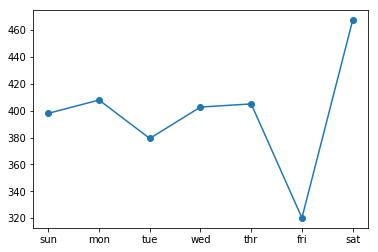

In [28]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Ejecutar el ejemplo se ajusta y evalúa el modelo, imprimiendo el RMSE general en los siete días y el RMSE por día para cada tiempo de entrega.

Sus resultados específicos pueden variar dada la naturaleza estocástica del algoritmo. Puede intentar ejecutar el ejemplo varias veces.

Podemos ver que en este caso, el modelo fue hábil en comparación con un pronóstico ingenuo, logrando un RMSE general de aproximadamente 399 kilovatios, menos de 465 kilovatios logrados por un modelo ingenuo.

También se crea un diagrama del RMSE diario.

La gráfica muestra que quizás los martes y viernes son días más fáciles de pronosticar que los otros días y que quizás el sábado al final de la semana estándar es el día más difícil de pronosticar.

Podemos aumentar el número de días anteriores para usar como entrada de siete a 14 cambiando la variable n_input .

Volver a ejecutar el ejemplo con este cambio primero imprime un resumen del rendimiento del modelo.

Sus resultados específicos pueden variar; intente ejecutar el ejemplo varias veces.

En este caso, podemos ver una nueva caída en el RMSE general a aproximadamente 370 kilovatios, lo que sugiere que un ajuste adicional del tamaño de entrada y quizás el número de nodos en el modelo puede resultar en un mejor rendimiento.

lstm: [370.028] 387.4, 377.9, 334.0, 371.2, 367.1, 330.4, 415.1

Al comparar los puntajes RMSE por día, vemos que algunos son mejores y otros peores que usar entradas de siete días.

Esto puede sugerir un beneficio al usar las dos entradas de diferentes tamaños de alguna manera, como un conjunto de los dos enfoques o tal vez un solo modelo (por ejemplo, un modelo de varias cabezas) que lee los datos de entrenamiento de diferentes maneras.

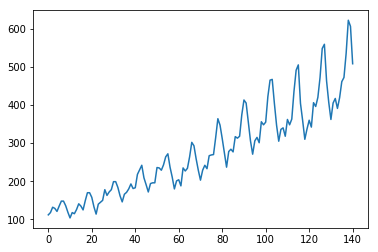

In [2]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1],
engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

# Perceptrones multicapa para regresión

Expresaremos el problema de predicción de series de tiempo como un problema de regresión. Es decir, dada la cantidad de pasajeros (en unidades de miles) de este mes, ¿cuál es la cantidad de pasajeros el mes que viene?

Podemos escribir una función simple para convertir nuestra única columna de datos en un conjunto de datos de dos columnas. La primera columna que contiene el recuento de pasajeros de este mes (t) y la segunda columna que contiene el recuento de pasajeros del mes siguiente (t + 1) que se va a predecir. Antes de comenzar, importemos primero todas las funciones y clases que pretendemos utilizar.

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
# fix random seed for reproducibility
numpy.random.seed(7)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


También podemos usar el código de la sección anterior para cargar el conjunto de datos como datos de Pandas. Luego podemos extraer la matriz NumPy de los datos y convertir los valores enteros en valores de punto flotante que sean más adecuados para modelar con una red neuronal.

In [4]:
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],
engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

Después de modelar nuestros datos y estimar la habilidad de nuestro modelo en el conjunto de datos de entrenamiento, necesitamos tener una idea de la habilidad del modelo en nuevos datos invisibles. Para un problema de clasificación o regresión normal, lo haríamos utilizando la validación cruzada de k-fold. Con los datos de series de tiempo, la secuencia de valores es importante. 

Un método simple que podemos usar es dividir el conjunto de datos ordenados en conjuntos de datos de prueba y entrenamiento. El siguiente código calcula el índice del punto de división y separa los datos en los conjuntos de datos de entrenamiento con el 67% de las observaciones que podemos usar para entrenar nuestro modelo, dejando el 33% restante para probar el modelo.

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

94 47


Ahora podemos definir una función para crear el nuevo conjunto de datos. La función toma dos argumentos, el conjunto de datos (dataset) que es una matriz NumPy que queremos convertir en un conjunto de datos y el look_back, que es el número de pasos de tiempo anteriores para usar como variables de entrada para predecir el siguiente período de tiempo, en este caso, predeterminado a 1. 

Este valor predeterminado creará un conjunto de datos donde X es el número de pasajeros en un momento dado (t) e Y es el número de pasajeros en el instante siguiente (t + 1). Se puede configurar y veremos cómo construir un conjunto de datos con formas diferentes en la siguiente sección.

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


La función anterior genera los siguientes resultados: 

X   Y

112 118

118 132

132 129

129 121

121 135




Si compara estas primeras 5 filas con la muestra de conjunto de datos original que se enumeró en la sección anterior, puede ver el patrón X = t e Y = t + 1 en los números. Usemos esta función para preparar el entrenamiento y prueba de los conjuntos de datos para el modelo.

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


Ahora podemos utilizar un modelo de Perceptron multicapa para los datos de entrenamiento. Utilizamos una red simple con 1 entrada, 1 capa oculta con 8 neuronas y una capa de salida. El modelo utiliza el error cuadrático medio, ya que si tomamos la raíz cuadrada nos da una puntuación de error en las unidades del conjunto de datos. Se utilizaron algunos parámetros aproximados y la siguiente configuración, pero de ninguna manera la red está optimizada.

In [8]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)

W1015 10:13:37.151838  2948 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 10:13:37.189840  2948 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 10:13:37.198841  2948 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 10:13:37.227842  2948 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Epoch 1/200
 - 0s - loss: 47086.4069
Epoch 2/200
 - 0s - loss: 41511.1617
Epoch 3/200
 - 0s - loss: 35815.8715
Epoch 4/200
 - 0s - loss: 30032.2988
Epoch 5/200
 - 0s - loss: 24207.5596
Epoch 6/200
 - 0s - loss: 18719.1566
Epoch 7/200
 - 0s - loss: 13726.1680
Epoch 8/200
 - 0s - loss: 9565.3403
Epoch 9/200
 - 0s - loss: 6312.3012
Epoch 10/200
 - 0s - loss: 3955.6866
Epoch 11/200
 - 0s - loss: 2412.6259
Epoch 12/200
 - 0s - loss: 1492.0580
Epoch 13/200
 - 0s - loss: 966.0848
Epoch 14/200
 - 0s - loss: 705.1835
Epoch 15/200
 - 0s - loss: 585.8438
Epoch 16/200
 - 0s - loss: 536.6327
Epoch 17/200
 - 0s - loss: 515.3387
Epoch 18/200
 - 0s - loss: 509.3032
Epoch 19/200
 - 0s - loss: 508.1827
Epoch 20/200
 - 0s - loss: 507.2037
Epoch 21/200
 - 0s - loss: 506.1274
Epoch 22/200
 - 0s - loss: 505.5802
Epoch 23/200
 - 0s - loss: 507.7889
Epoch 24/200
 - 0s - loss: 508.3767
Epoch 25/200
 - 0s - loss: 505.9807
Epoch 26/200
 - 0s - loss: 508.9310
Epoch 27/200
 - 0s - loss: 507.8845
Epoch 28/200
 - 0s

Una vez que el modelo está en condiciones, podemos estimar el rendimiento del modelo en los conjuntos de datos de entrenamiento y prueba. Esto nos dará un punto de comparación para los nuevos modelos.

In [9]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 502.99 MSE (22.43 RMSE)
Test Score: 2048.78 MSE (45.26 RMSE)


Finalmente, podemos generar predicciones utilizando el modelo tanto para el entrenamiento como para el conjunto de datos de prueba para obtener una indicación visual de la habilidad del modelo. Debido a cómo se preparó el conjunto de datos, debemos cambiar las predicciones para que se alineen en el eje x con el conjunto de datos original. Una vez preparados los datos, se trazan en azul el conjunto de datos original, en amarillo las predicciones para el conjunto de datos del entrenamiento, y en verde las predicciones en el conjunto de datos de prueba.

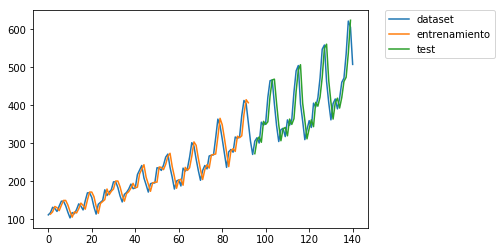

In [10]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()


# Código completo



96 48
Epoch 1/200


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


 - 1s - loss: 47573.3689
Epoch 2/200
 - 0s - loss: 41638.7982
Epoch 3/200
 - 0s - loss: 35671.4853
Epoch 4/200
 - 0s - loss: 29455.6100
Epoch 5/200
 - 0s - loss: 23367.0042
Epoch 6/200
 - 0s - loss: 17667.2450
Epoch 7/200
 - 0s - loss: 12724.6766
Epoch 8/200
 - 0s - loss: 8635.7736
Epoch 9/200
 - 0s - loss: 5550.5634
Epoch 10/200
 - 0s - loss: 3407.6441
Epoch 11/200
 - 0s - loss: 2050.7950
Epoch 12/200
 - 0s - loss: 1280.0152
Epoch 13/200
 - 0s - loss: 862.0540
Epoch 14/200
 - 0s - loss: 672.5996
Epoch 15/200
 - 0s - loss: 584.1580
Epoch 16/200
 - 0s - loss: 554.7161
Epoch 17/200
 - 0s - loss: 546.6044
Epoch 18/200
 - 0s - loss: 547.3599
Epoch 19/200
 - 0s - loss: 538.8208
Epoch 20/200
 - 0s - loss: 538.5310
Epoch 21/200
 - 0s - loss: 536.9808
Epoch 22/200
 - 0s - loss: 536.0285
Epoch 23/200
 - 0s - loss: 537.1251
Epoch 24/200
 - 0s - loss: 535.7831
Epoch 25/200
 - 0s - loss: 538.2119
Epoch 26/200
 - 0s - loss: 538.4747
Epoch 27/200
 - 0s - loss: 538.2312
Epoch 28/200
 - 0s - loss: 537

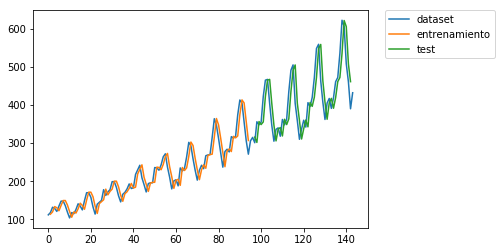

In [63]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],engine='python', skipfooter=3)
dataset = dataframe.values

dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Tomando la raíz cuadrada de las estimaciones del rendimiento obtenido, podemos ver que el modelo tiene un error promedio de 23 pasajeros (en miles) en el conjunto de datos de entrenamiento y 48 pasajeros (en miles) en el conjunto de datos de prueba.

# Perceptrón multicapa usando el método de la ventana

También podemos plantear el problema para que se puedan usar múltiples pasos de tiempo recientes para hacer la predicción para el siguiente paso de tiempo. Esto se denomina método de ventana, y el tamaño de la ventana es un parámetro que puede ajustarse para cada problema. Por ejemplo, dado el tiempo actual (t) queremos predecir el valor la próxima vez en la secuencia (t + 1), podemos usar el tiempo actual (t) así como los dos tiempos anteriores (t-1 y t-2). Cuando se expresan como un problema de regresión, las variables de entrada son t-2, t-1, t y la variable de salida es t + 1.

La función que crea el conjunto de datos "create_dataset()" que escribimos en la sección anterior nos permite realizar la formulación del problema de series de tiempo al aumentar el argumento de retrospectiva "look_back" de 1 a 3. Un ejemplo del dataset usando el método de ventana se muestra a continuación:

X1  X2  X3  Y

112 118 132 129

118 132 129 121

132 129 121 135

129 121 135 148

121 135 148 148


Podemos volver a ejecutar el ejemplo en la sección anterior con el tamaño de ventana más grande. La lista del código completo, con solo el cambio de tamaño de la ventana, se muestra a continuación:

96 48
Epoch 1/200


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


 - 1s - loss: 80862.0196
Epoch 2/200
 - 0s - loss: 19707.2359
Epoch 3/200
 - 0s - loss: 3201.0891
Epoch 4/200
 - 0s - loss: 1715.0414
Epoch 5/200
 - 0s - loss: 1672.3441
Epoch 6/200
 - 0s - loss: 1657.2667
Epoch 7/200
 - 0s - loss: 1657.7613
Epoch 8/200
 - 0s - loss: 1642.9549
Epoch 9/200
 - 0s - loss: 1634.7004
Epoch 10/200
 - 0s - loss: 1578.6332
Epoch 11/200
 - 0s - loss: 1568.9800
Epoch 12/200
 - 0s - loss: 1570.3814
Epoch 13/200
 - 0s - loss: 1583.4044
Epoch 14/200
 - 0s - loss: 1497.4383
Epoch 15/200
 - 0s - loss: 1468.8563
Epoch 16/200
 - 0s - loss: 1476.6651
Epoch 17/200
 - 0s - loss: 1405.4410
Epoch 18/200
 - 0s - loss: 1388.6921
Epoch 19/200
 - 0s - loss: 1386.3222
Epoch 20/200
 - 0s - loss: 1387.3355
Epoch 21/200
 - 0s - loss: 1346.7680
Epoch 22/200
 - 0s - loss: 1302.4153
Epoch 23/200
 - 0s - loss: 1362.4998
Epoch 24/200
 - 0s - loss: 1267.0884
Epoch 25/200
 - 0s - loss: 1242.7564
Epoch 26/200
 - 0s - loss: 1234.9297
Epoch 27/200
 - 0s - loss: 1258.4246
Epoch 28/200
 - 0s -

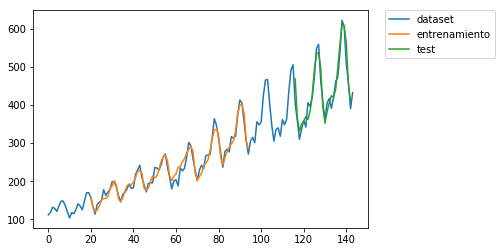

In [74]:
# Multilayer Perceptron to Predict International Airline Passengers 
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],engine='python', skipfooter=3)
dataset = dataframe.values

dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
          
          


Podemos ver que el error se redujo en comparación con el de la sección anterior. Nuevamente, el tamaño de la ventana y la arquitectura de la red no se ajustaron, esto es solo una demostración de cómo realizar un problema de predicción. Tomando la raíz cuadrada de los puntajes de rendimiento, podemos ver que el error promedio en el conjunto de datos de entrenamiento fue de 14 pasajeros (en miles por mes) y el error promedio en el conjunto de pruebas fue de 25 pasajeros (en miles por mes).

# Red LSTM para Regresión

Desarrollaremos una serie de LSTM para un problema de predicción de series de tiempo estándar. El problema y la configuración elegida para las redes LSTM son solo para fines de demostración, no están optimizados. Estos ejemplos mostrarán exactamente cómo puede desarrollar sus propias redes LSTM para problemas de modelado predictivo de series temporales.

El problema que veremos es el problema de predicción de los pasajeros de las aerolíneas internacionales. Es decir, dada la cantidad de pasajeros (en unidades de miles) de este mes, ¿cuál es la cantidad de pasajeros el mes que viene? Este ejemplo reutilizará la misma carga y preparación de datos usados anteriormente, específicamente el uso de la función crear conjunto de datos llamada create_dataset().

Las redes LSTM son sensibles a la escala de los datos de entrada, específicamente cuando se utilizan las funciones de activación sigmoide (predeterminado) o tanh. Puede ser una buena práctica volver a escalar los datos al rango de 0 a 1, también llamada normalización. Podemos normalizar fácilmente el conjunto de datos utilizando la clase de preprocesamiento MinMaxScaler de la biblioteca scikit-learn.


In [75]:
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

La red LSTM espera que los datos de entrada (X) se proporcionen con una estructura de matriz específica en forma de:

[muestras, pasos de tiempo, características]

Nuestros datos preparados están en la forma: 

[muestras, características] 

Estamos enmarcando el problema como un paso de tiempo para cada muestra. Podemos transformar los datos de entrenamiento y prueba en la estructura esperada usando la funcion numpy.reshape() de la siguiente manera:

In [78]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Ahora estamos listos para diseñar y entrenar nuestra red LSTM para este problema. La red tiene una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM (neuronas) y una capa de salida que hace una predicción de valor único. Se utiliza la función de activación sigmoide predeterminada para los bloques de memoria LSTM. La red será entrenada para 100 épocas y se utiliza un tamaño de lote de 1.

In [81]:
from keras.layers import LSTM
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 20))`
  after removing the cwd from sys.path.
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/100
 - 1s - loss: 58973.6500
Epoch 2/100
 - 1s - loss: 58768.4230
Epoch 3/100
 - 1s - loss: 58628.0244
Epoch 4/100
 - 1s - loss: 58406.1284
Epoch 5/100
 - 1s - loss: 58204.3717
Epoch 6/100
 - 1s - loss: 58081.5364
Epoch 7/100
 - 1s - loss: 57970.9101
Epoch 8/100
 - 1s - loss: 57860.3919
Epoch 9/100
 - 1s - loss: 57750.1858
Epoch 10/100
 - 1s - loss: 57640.3709
Epoch 11/100
 - 1s - loss: 57531.0244
Epoch 12/100
 - 1s - loss: 57420.9019
Epoch 13/100
 - 1s - loss: 57312.4566
Epoch 14/100
 - 1s - loss: 57203.0905
Epoch 15/100
 - 1s - loss: 57094.0684
Epoch 16/100
 - 1s - loss: 56985.6529
Epoch 17/100
 - 1s - loss: 56876.9160
Epoch 18/100
 - 1s - loss: 56768.9285
Epoch 19/100
 - 1s - loss: 56660.3395
Epoch 20/100
 - 1s - loss: 56552.6527
Epoch 21/100
 - 1s - loss: 56445.0465
Epoch 22/100
 - 1s - loss: 56337.4417
Epoch 23/100
 - 1s - loss: 56230.1534
Epoch 24/100
 - 1s - loss: 56122.8605
Epoch 25/100
 - 1s - loss: 56015.5449
Epoch 26/100
 - 1s - loss: 55908.5045
Epoch 27/100
 - 1s - 

# Código Completo LSTM


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 1))`
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
 - 2s - loss: 0.0414
Epoch 2/100
 - 1s - loss: 0.0202
Epoch 3/100
 - 1s - loss: 0.0145
Epoch 4/100
 - 1s - loss: 0.0131
Epoch 5/100
 - 1s - loss: 0.0121
Epoch 6/100
 - 1s - loss: 0.0111
Epoch 7/100
 - 1s - loss: 0.0102
Epoch 8/100
 - 1s - loss: 0.0093
Epoch 9/100
 - 1s - loss: 0.0081
Epoch 10/100
 - 1s - loss: 0.0071
Epoch 11/100
 - 1s - loss: 0.0062
Epoch 12/100
 - 1s - loss: 0.0053
Epoch 13/100
 - 1s - loss: 0.0045
Epoch 14/100
 - 1s - loss: 0.0038
Epoch 15/100
 - 1s - loss: 0.0033
Epoch 16/100
 - 1s - loss: 0.0029
Epoch 17/100
 - 1s - loss: 0.0026
Epoch 18/100
 - 1s - loss: 0.0024
Epoch 19/100
 - 1s - loss: 0.0022
Epoch 20/100
 - 1s - loss: 0.0022
Epoch 21/100
 - 1s - loss: 0.0021
Epoch 22/100
 - 1s - loss: 0.0021
Epoch 23/100
 - 1s - loss: 0.0021
Epoch 24/100
 - 1s - loss: 0.0021
Epoch 25/100
 - 1s - loss: 0.0020
Epoch 26/100
 - 1s - loss: 0.0021
Epoch 27/100
 - 1s - loss: 0.0020
Epoch 28/100
 - 1s - loss: 0.0020
Epoch 29/100
 - 1s - loss: 0.0020
Epoch 30/100
 - 1s - lo

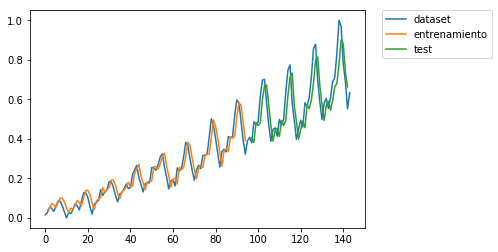

In [84]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
          

Tomando la raíz cuadrada e invirtiendo la escala transformada de las estimaciones de rendimiento, podemos ver que el modelo tiene un error promedio de aproximadamente 127 pasajeros (en miles) en el conjunto de datos de entrenamiento y alrededor de 154 pasajeros (en miles) en el conjunto de datos de prueba. 

# LSTM para regresión usando el método de ventana

Al igual que en el caso de la red multicapa, podemos realizar el método de ventana con redes LSTM. De esta manera podemos elegir diferentes instantes de tiempo t para realizar la predicción. 

Un ejemplo variando la ventana a 20 se muestra a continuación. 


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 3))`
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
 - 2s - loss: 0.0544
Epoch 2/100
 - 1s - loss: 0.0259
Epoch 3/100
 - 1s - loss: 0.0167
Epoch 4/100
 - 1s - loss: 0.0145
Epoch 5/100
 - 1s - loss: 0.0129
Epoch 6/100
 - 1s - loss: 0.0117
Epoch 7/100
 - 1s - loss: 0.0105
Epoch 8/100
 - 1s - loss: 0.0094
Epoch 9/100
 - 1s - loss: 0.0081
Epoch 10/100
 - 1s - loss: 0.0074
Epoch 11/100
 - 1s - loss: 0.0066
Epoch 12/100
 - 1s - loss: 0.0060
Epoch 13/100
 - 1s - loss: 0.0056
Epoch 14/100
 - 1s - loss: 0.0052
Epoch 15/100
 - 1s - loss: 0.0050
Epoch 16/100
 - 1s - loss: 0.0049
Epoch 17/100
 - 1s - loss: 0.0046
Epoch 18/100
 - 1s - loss: 0.0045
Epoch 19/100
 - 1s - loss: 0.0045
Epoch 20/100
 - 1s - loss: 0.0043
Epoch 21/100
 - 1s - loss: 0.0043
Epoch 22/100
 - 1s - loss: 0.0042
Epoch 23/100
 - 1s - loss: 0.0042
Epoch 24/100
 - 1s - loss: 0.0042
Epoch 25/100
 - 1s - loss: 0.0040
Epoch 26/100
 - 1s - loss: 0.0041
Epoch 27/100
 - 1s - loss: 0.0040
Epoch 28/100
 - 1s - loss: 0.0040
Epoch 29/100
 - 1s - loss: 0.0039
Epoch 30/100
 - 1s - lo

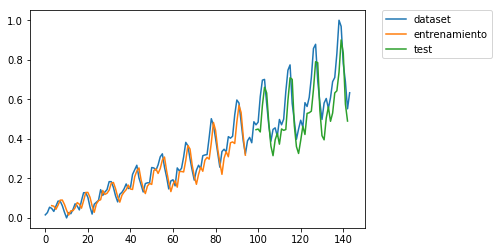

In [88]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
          

# LSTM para regresión usando pasos de tiempo (time steps)

Es posible que haya notado que la preparación de datos para la red LSTM incluye pasos de tiempo. Algunos problemas de secuencia pueden tener un número variado de pasos de tiempo por muestra. Por ejemplo, puede tener mediciones de una máquina física que conduce a un punto de falla o a un punto de sobrecarga. Cada incidente sería una muestra, las observaciones que condujeron al evento serían los pasos de tiempo y las variables observadas serían las características. 

Los pasos de tiempo proporcionan otra manera de expresar nuestro problema de series de tiempo. Como en el ejemplo anterior de la ventana, podemos tomar pasos de tiempo previos en nuestra serie de tiempo como entradas para predecir la salida en el siguiente paso de tiempo.

En lugar de expresar las observaciones pasadas como características de entrada separadas, podemos usarlas como pasos de tiempo de la característica de una entrada, lo que de hecho es un enfoque más preciso del problema. Podemos hacer esto usando la misma representación de datos que en el ejemplo anterior basado en la ventana, excepto que cuando cambiamos la forma de los datos, establecemos las columnas como la dimensión de los pasos de tiempo y cambiamos la dimensión de las características de nuevo a 1. Por ejemplo:

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Código Completo LSTM con time steps

Podemos ver que los resultados generalmente están a la par con el ejemplo anterior, aunque la estructura de los datos de entrada tiene más sentido.


C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 1))`
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
 - 2s - loss: 0.0287
Epoch 2/100
 - 1s - loss: 0.0117
Epoch 3/100
 - 1s - loss: 0.0097
Epoch 4/100
 - 1s - loss: 0.0086
Epoch 5/100
 - 1s - loss: 0.0074
Epoch 6/100
 - 1s - loss: 0.0065
Epoch 7/100
 - 1s - loss: 0.0058
Epoch 8/100
 - 1s - loss: 0.0053
Epoch 9/100
 - 1s - loss: 0.0045
Epoch 10/100
 - 1s - loss: 0.0044
Epoch 11/100
 - 1s - loss: 0.0041
Epoch 12/100
 - 1s - loss: 0.0041
Epoch 13/100
 - 1s - loss: 0.0040
Epoch 14/100
 - 1s - loss: 0.0039
Epoch 15/100
 - 1s - loss: 0.0039
Epoch 16/100
 - 1s - loss: 0.0039
Epoch 17/100
 - 1s - loss: 0.0038
Epoch 18/100
 - 1s - loss: 0.0039
Epoch 19/100
 - 1s - loss: 0.0038
Epoch 20/100
 - 1s - loss: 0.0038
Epoch 21/100
 - 1s - loss: 0.0038
Epoch 22/100
 - 1s - loss: 0.0038
Epoch 23/100
 - 1s - loss: 0.0037
Epoch 24/100
 - 1s - loss: 0.0038
Epoch 25/100
 - 1s - loss: 0.0037
Epoch 26/100
 - 1s - loss: 0.0038
Epoch 27/100
 - 1s - loss: 0.0037
Epoch 28/100
 - 1s - loss: 0.0038
Epoch 29/100
 - 1s - loss: 0.0037
Epoch 30/100
 - 1s - lo

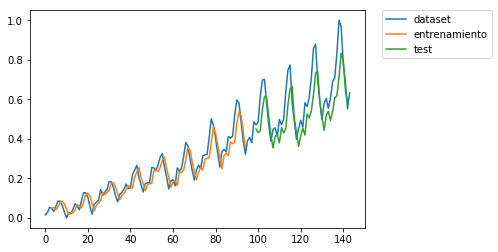

In [87]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# LSTM con memoria entre lotes (batches)

La red LSTM tiene una memoria que es capaz de recordar en secuencias largas. Normalmente, el estado dentro de la red se restablece después de cada lote de entrenamiento al ajustar el modelo, así como cada llamada a la predicción model.predict() o model.evaluate(). 

Podemos ganar control sobre cuándo se borra el estado interno de la red LSTM en Keras al hacer que la capa LSTM sea estable. Esto significa que puede construir un estado en toda la secuencia de entrenamiento e incluso mantener ese estado si es necesario para hacer predicciones.

Se requiere que los datos de entrenamiento no se barajen al configurar la red. También requiere un restablecimiento explícito (reset) del estado de la red después de cada exposición a los datos de entrenamiento (época) mediante llamadas a los estados del modelo model.reset(). Esto significa que debemos crear nuestro propio bucle exterior de épocas y dentro de cada época llamar a model.fit() y model.reset states(), por ejemplo:

In [ ]:
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Finalmente, cuando se construye la capa LSTM, el parámetro con estado debe establecerse en verdadero y, en lugar de especificar las dimensiones de entrada, debemos codificar la cantidad de muestras en un lote, la cantidad de pasos de tiempo en una muestra y la cantidad de entidades en un paso de tiempo configurando el parámetro de forma de entrada por lotes. Por ejemplo:

In [ ]:
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))

Este mismo tamaño de lote se debe usar más adelante al evaluar el modelo y hacer predicciones. Por ejemplo:

In [ ]:
model.predict(trainX, batch_size=batch_size)

Podemos adaptar el ejemplo de paso de tiempo anterior para usar un LSTM con estado. El código completo se proporciona a continuación.

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
 - 2s - loss: 0.0048
Epoch 1/1
 - 1s - loss: 0.0082
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0048
Epoch 1/1
 - 1s - loss: 0.0047
Epoch 1/1
 - 1s - loss: 0.0047
Epoch 1/1
 - 1s - loss: 0.0047
Epoch 1/1
 - 1s - loss: 0.0046
Epoch 1/1
 - 1s - loss: 0.0045
Epoch 1/1
 - 1s - loss: 0.0045
Epoch 1/1
 - 1s - loss: 0.0044
Epoch 1/1
 - 1s - loss: 0.0043
Epoch 1/1
 - 1s - loss: 0.0043
Epoch 1/1
 - 1s - loss: 0.0042
Epoch 1/1
 - 1s - loss: 0.0042
Epoch 1/1
 - 1s - loss: 0.0041
Epoch 1/1
 - 1s - loss: 0.0041
Epoch 1/1
 - 1s - loss: 0.0040
Epoch 1/1
 - 1s - loss: 0.0040
Epoch 1/1
 - 1s - loss: 0.0039
Epoch 1/1
 - 1s - loss: 0.0038
Epoch 1/1
 - 1s - loss: 0.0037
Epoch 1/1
 - 1s - loss: 0.0037
Epoch 1/1
 - 1s - loss: 0.0036
Epoch 1/1
 - 1s - loss: 0.0035
Epoch 1/1
 - 1s - loss: 0.0034
Epoch 1/1
 - 1s - loss: 0.0033
Epoch 1/1
 - 1s - loss: 0.0032
Epoch 1/1
 - 1s - loss: 0.0032
Epoch 1/1
 - 1s - loss: 0.0031
Epoch 1/1
 - 1s - loss: 0.0030
Epoch 1/1
 - 1s - loss: 0.0029
Epoch 1/

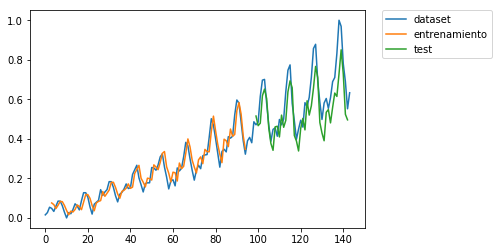

In [89]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],
engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
model.reset_states()
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
model.reset_states()
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))
# generate predictions for training
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# LSTM apiladas con memoria entre lotes (batches)

Finalmente, veremos uno de los grandes beneficios de los LSTM, el hecho de que se pueden entrenar con éxito cuando se integran en arquitecturas de redes profundas. Las redes LSTM se pueden apilar en Keras de la misma manera que otros tipos de capas se pueden apilar. Note que en la configuración, la capa LSTM antes de cada capa LSTM subsiguiente debe devolver la secuencia. Esto se puede hacer estableciendo el parámetro de secuencias de retorno en la capa en Verdadero. Podemos extender el estado LSTM en la sección anterior para tener dos capas, de la siguiente manera:

In [ ]:
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))

El código completo es presentado a continuación:

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
 - 3s - loss: 0.0057
Epoch 1/1
 - 2s - loss: 0.0141
Epoch 1/1
 - 2s - loss: 0.0099
Epoch 1/1
 - 2s - loss: 0.0072
Epoch 1/1
 - 2s - loss: 0.0060
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/

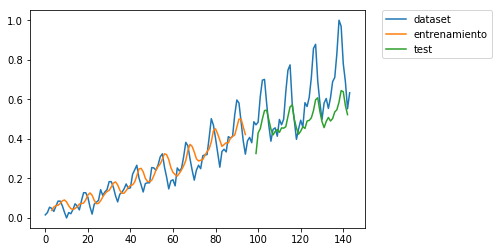

In [90]:
# Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1],
engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True,return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
model.reset_states()
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
model.reset_states()
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

# generate predictions for training
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset, label="dataset")
plt.plot(trainPredictPlot, label="entrenamiento")
plt.plot(testPredictPlot, label="test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()